# SC1 Demonstrator 
## Geo Spatial Imagery Processing And Analysis 

This notebook serves as a demonstrator of a complete workflow for of Sentinel Geo Spatial imagery processing and analysis.

# Table of content

* 1. [Weaver](#1.-Weaver)
* 2. [Sentinel-1 Ingest](#2.-Sentinel-1-Ingest)
        * 2.1 [Sci-Hub account creation](#2.1-Sci-Hub-account-creation)
        * 2.2 [External Catalog Consulting](#2.2-External-Catalog-Consulting)
            * 2.2.1 [Search request information](#2.2.1-Search-request-information)
            * 2.2.2 [Search Query Result](#2.2.2-Search-Query-Result)
        * 2.3 [Visualising The Search Results](#2.3-Visualising-The-Search-Results)
        * 2.4 [Product availability](#2.4-Product-availability)
        * 2.5 [Product Download With Weaver](#2.5-Product-Download-With-Weaver)
* 3. [Datacube Formation using Weaver](#3.-Datacube-Formation-using-Weaver)
        * 3.1 [Image processing](#3.1-Image-processing)
        * 3.2 [Image coregistration](#3.2-Image-coregistration)
        * 3.3 [Metadata Exploration Of A NetCDF Datacube](#3.3-Metadata-Exploration-Of-A-NetCDF-Datacube)
* 4. [SAR Multi-Temporal Analysis](#4.-SAR-Multi-Temporal-Analysis)
        * 4.1 [Step 1: Compute Statistics Along The Time Dimension](#4.1-Step-1:-Compute-Statistics-Along-The-Time-Dimension)
        * 4.2 [Step 2: Outliers Detection](#4.2-Step-2:-Outliers-Detection)
        * 4.3 [Computation Of A HSV Composite](#4.3-Computation-Of-A-HSV-Composite)
* 5. [Publish To Catalog](#5.-Publish-To-Catalog)

---
**NOTE**

This demonstrator notebook relies on the availability of certain online products and heavy image processing. Because of the long download and rendering of the processes, some sections of this demo are not supposed to work and are there only as an example. 

The concerned sections: 
* 2.5 [Product Download With Weaver](#2.5-Product-Download-With-Weaver)
* 3. [Datacube Formation using Weaver](#3.-Datacube-Formation-using-Weaver)

---

# 1. Weaver 

Weaver allows the execution of workflows chaining various applications, OGC API Processes and Web Processing Services inputs and outputs.<br/>
* [Weaver Documentation](https://pavics-weaver.readthedocs.io/en/latest/)  <br/>
* [Weaver Github](https://github.com/crim-ca/weaver)<br/>

In [145]:
import os
from weaver.cli import WeaverClient
from requests_magpie import MagpieAuth

First we need to define and instanciate the Weaver client to be used for executing the processes of geo spatial imagery processing and analysis.

In [2]:
# Weaver setup
WEAVER_URL = os.getenv('WEAVER_URL')

# Authentication 
MAGPIE_URL = os.getenv('MAGPIE_URL')
MAGPIE_USER = os.getenv('MAGPIE_USER')
MAGPIE_PASS = os.getenv('MAGPIE_PASS)

# Magpie Authentication
aCMagpieAuth = MagpieAuth(MAGPIE_URL, MAGPIE_USER, MAGPIE_PASS)

# Instanciate a weaver client with magpie authentication
wclient = WeaverClient(url=WEAVER_URL, auth=aCMagpieAuth)

In [3]:
# # Getting the available processes and validating that we have the processes needed: 
# 1. sentinelsat_batch_download 
# 2. eo_tools
wclient.capabilities().body['processes']

['eo_tools',
 'file_index_selector',
 'file2string_array',
 'jsonarray2netcdf',
 'metalink2netcdf',
 'sentinelsat_batch_download',
 'sentinelsat_download']

# 2. Sentinel-1 Ingest

In this section we are going to look at how to ingest spatial images. </br>
More specificly we will be able to explore, search and download for available images(products).

---
**NOTE**

This section is tho show the user a method to explore and download sentinel products.
If you already have the product ready for the processing skip to the the section : [3. Datacube Formation using Weaver](#3.-Datacube-Formation-using-Weaver)

---

### Documentation

For the users willing to use the SentinelSat librarie:
- [Sentinelsat](https://sentinelsat.readthedocs.io/en/stable/)<br/>


## 2.1 Sci-Hub account creation
**To realise this part, a Sci-Hub account allowing to access Copernicus data, will be needed**

To download Sentinel imagery through the Copernicus Open Access Hub, a personal account must first be created here: https://scihub.copernicus.eu/dhus/#/self-registration

Once completed, an email will be sent to your address so the registration can be finalized. 

With your new Copernicus username and password, you will then be able to use the Sentinel imagery downloading service of the DACCS platform, or directly on your own computer with the help of Python libraries like Sentinelsat or OpenSarToolkit, or even directly through the Copernicus Open Access Hub.

We have to keep in mind that the EESA Copernicus archives the unused images into his <b>Long Term Archive (LTA)</b>. For instance if you try to download an unavailable image, they will specify that the image is not availblle for the moment until it has been removed from archives. Any archived image receives a request for availability once it's tried to be downloaded. 

In [36]:
import json
import geojson
import geopandas
import folium
from pprint import pprint
from getpass import getpass
from IPython.display import HTML

import requests
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt

In [218]:
# Api instance with copernicus credentials
print("Copernicus credentials (https://scihub.copernicus.eu/)")

api = SentinelAPI(input("Username : "), 
                  getpass("Password : "), 
                  'https://apihub.copernicus.eu/apihub')

Copernicus credentials (https://scihub.copernicus.eu/)
Username : <USER_NAME>
Password : ········


## 2.2 External Catalog Consulting

The following search in the catalogs will try to find the images based on these specs :
See spec here : https://www.crim.ca/confluence/display/DAC/Data+Cube+Specifications

| Parameters              | Value |
| :---------------- | :------: |
| Pass      |   Ascending   |
| Footprint           |   POLYGON((-76.752617 46.309341,-73.452034 46.706619,-73.092445 45.089809,-76.29631 44.693043,-76.752617 46.309341))   |
| Track (relative orbit number)   |  33   |
| Polarization |  VV and VH   |
| Subswath |  	IW3   |

### 2.2.1 Search request information

This is an exemple of catalog search to find this image: [DC1-Montreal](https://crim-ca.atlassian.net/wiki/spaces/DAC/pages/9962764/Data+Cube+Specifications)

We are going to use the query system from SentinelSat wrap arround the Copernicus query system.</br>
* SentinelSat Query : [Param](https://sentinelsat.readthedocs.io/en/stable/_modules/sentinelsat/sentinel.html#SentinelAPI.query)
* Copernicus List of valid query : [Param](https://scihub.copernicus.eu/twiki/do/view/SciHubUserGuide/FullTextSearch?redirectedfrom=SciHubUserGuide.3FullTextSearch)

In [52]:
# Generates a footprint area as a Well-Known-Text(WKT)
def generate_geojson(x_min, y_min, x_max, y_max):
    polygon = geojson.Polygon([[(x_min, y_min),(x_max, y_min),(x_max, y_max),(x_min, y_max),(x_min, y_min)]])
    feature = geojson.Feature(geometry=polygon)
    geojson_geometry = geojson.FeatureCollection([feature])
    return geojson_geometry

In [59]:
# Coordinates of the Region of interest
x_min = -76.8164 
y_min =  42.2935
x_max = -70.8398
y_max =  48.8068

# Generate a Well-Known-Text(wkt) as footprint
roi_geojson = generate_geojson(x_min, y_min, x_max, y_max)
roi_footprint = geojson_to_wkt(roi_geojson)


# Query arguments to try to find a product fitting our parameters 
query_kwargs = {
        'area': roi_footprint,
        'platformname': 'Sentinel-1',
        'orbitdirection': 'Ascending',
        'order_by': None,
        'limie': None,
        'relativeorbitnumber': '33',
        'swathidentifier': 'IW3',
        'date': ('2023-06-16T22:52:18Z','2023-07-30T22:52:50Z'),
        'polarisationmode': 'VV VH'}

In [117]:
# SentinelSat Api request
products = api.query(**query_kwargs)

### 2.2.2 Search Query Result

Once we made the query call to get all the product from the paramaters specified earlier`(query_kwargs)`, we can explore and look to check if there is a match for the product we are looking for. Keep in mind that these are all the product, maybe the are available or the also might be archieved.

> **Important**</br>
> Keep in mind that the EESA Copernicus archives the unused images into his <b>Long Term Archive (LTA)</b>. For instance if you try to download an unavailable image, they will specify that the image is not availblle for the moment until it has been removed from archives. Any archived image receives a request for availability once it's tried to be downloaded. 

In [121]:
# Convert the search result to dataframe
products_df = api.to_dataframe(products)

In [122]:
# Add LTA column wich define returns whether the product is online. { True: online, Flase: archived }
lamba = products_df.apply(lambda x: api.is_online(x['uuid']), axis=1)

products_df.insert(loc=0, 
                   column='isonline', 
                   value=lamba)


In [140]:
products_df[:3][['isonline','size','title']]

isonline     size  \
a512427d-867f-4c83-a3bc-9b7e770e0c5c    False  6.86 GB   
af08e2f3-4d96-46e8-ae40-de2d38fa3ef4    False  7.34 GB   
124af806-ebc9-4f21-b5f3-f2798bea2c31    False  7.34 GB   

                                                                                  title  
a512427d-867f-4c83-a3bc-9b7e770e0c5c  S1A_IW_SLC__1SDV_20230728T225156_20230728T2252...  
af08e2f3-4d96-46e8-ae40-de2d38fa3ef4  S1A_IW_SLC__1SDV_20230716T225221_20230716T2252...  
124af806-ebc9-4f21-b5f3-f2798bea2c31  S1A_IW_SLC__1SDV_20230716T225336_20230716T2254...

In [43]:
# Complete information about a single product
pprint(products_df.iloc[0])

isonline                                                               False
title                      S1A_IW_SLC__1SDV_20230728T225156_20230728T2252...
link                       https://apihub.copernicus.eu/apihub/odata/v1/P...
link_alternative           https://apihub.copernicus.eu/apihub/odata/v1/P...
link_icon                  https://apihub.copernicus.eu/apihub/odata/v1/P...
summary                    Date: 2023-07-28T22:51:56.643Z, Instrument: SA...
ondemand                                                               false
beginposition                                     2023-07-28 22:51:56.643000
endposition                                       2023-07-28 22:52:22.771000
ingestiondate                                     2023-07-29 08:08:27.099000
missiondatatakeid                                                     391116
slicenumber                                                                7
orbitnumber                                                            49630

In [44]:
# Converting the result to geojson
products_json = api.to_geojson(products)

## 2.3 Visualising The Search Results

This is a simple example of how to visualise the products on a map.

In [49]:
# Converting search results to geo dataframe
areas = api.to_geodataframe(products)

# Converting search result to geo dataframe
df = api.to_geodataframe(products)

# Folium map instance
m = folium.Map(width=1000, height=500,location=[45.508888, -73.561668], zoom_start=6)

# Adding the ROI to the map
folium.GeoJson(data=roi_geojson,
               name='Region of interest').add_to(m)


# Adding the search resuls from the sentinelsat request to the map
for _, r in df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = geopandas.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           name=r['title'],
                           style_function=lambda x: {'fillColor': 'orange'})
    
    folium.Popup("uudi : "+r['uuid']+"\n" +"Title : " +r['title']).add_to(geo_j)
    
    geo_j.add_to(m)

folium.LayerControl().add_to(m)    
m

![sentinelsat_products_map](images/sentinelsat_products_map.png)

## 2.4 Product availability

If the product needed is not available and is archived, we can use the [trigger_offline_retrieval](https://sentinelsat.readthedocs.io/en/stable/api_reference.html?highlight=trigger_offline_retrieval#sentinelsat.sentinel.SentinelAPI.trigger_offline_retrieval) method to make them available for download. 

In [73]:
# Choosing the first two product for retrieval, meaning 
products = products_df[:2]['uuid'].to_list()

[api.trigger_offline_retrieval(product) for product in products]

[True, True]

In [115]:
# We can validate that our product triggered are now available
products_df[:3][['isonline','size','title']]

isonline     size  \
a512427d-867f-4c83-a3bc-9b7e770e0c5c     True  6.86 GB   
af08e2f3-4d96-46e8-ae40-de2d38fa3ef4     True  7.34 GB   
124af806-ebc9-4f21-b5f3-f2798bea2c31    False  7.34 GB   

                                                                                  title  
a512427d-867f-4c83-a3bc-9b7e770e0c5c  S1A_IW_SLC__1SDV_20230728T225156_20230728T2252...  
af08e2f3-4d96-46e8-ae40-de2d38fa3ef4  S1A_IW_SLC__1SDV_20230716T225221_20230716T2252...  
124af806-ebc9-4f21-b5f3-f2798bea2c31  S1A_IW_SLC__1SDV_20230716T225336_20230716T2254...

## 2.5 Product Download With Weaver 
For the execution, Weaver expect a payload containing the inputs.
Because our process is a downloader of Spatial sentinel images we will need two inputs:
1. <b> The credentials file</b> 

2. <b>The name of the image to be downloaded</b>

* **Important note** </br>
Because copernicus archives the product, if it has not been used or downloaded in a long time and therfor the product is archived, our SentinelSat download process might finish successfully without downloading the file. That is because Weaver does not have a retry on fail. So for this example we will use an online product. 

In [31]:
from tempfile import NamedTemporaryFile

In [219]:
# Defining the credentials for the copernicus api used by the sentinelsat_batch_download process 
print(" Enter your copernicus credentials here :")
credentials = {
    "username": input("\tUsername: "),
    "password": getpass("\tPassword: ")
}


# Save credentials as file 
credentials_file = NamedTemporaryFile(encoding="UTF-8", suffix=".json")

json.dump(credentials, credentials_file)
credentials_file.flush()

credentials_file_path = credentials_file.name

 Enter your copernicus credentials here :
	Username: <USER_NAME>
	Password: ········


In [15]:
# Defining the products we need to download
products = [
    "S2A_MSIL2A_20200520T154911_N0214_R054_T18TXR_20200520T201415",
    "S2A_MSIL2A_20220510T154821_N0400_R054_T18TXR_20220510T230512"
]

In [142]:
# Defining the dictionary or json to be sent to weaver to be used as inputs for the process to be executed 
sentinelsat_batch_download_inputs = {
  "mode": "async",
  "response": "document",
  "inputs": [
    {
      "id": "credentials",
      "href": f'{credentials_file_path}',
      "type": 'application/json',
    },
    {
      "id": "image",
      "data": products[0]
    },
    {
      "id": "image",
      "data": products[1]
    }
  ],
  "outputs": [
    {
      "id": "output",
      "transmissionMode": "reference"
    }
  ]
}

In [ ]:
# Executing the download process trought weaver
execute_response = wclient.execute(process_id="sentinelsat_batch_download", inputs=sentinelsat_batch_download_inputs)

# This will delete de temporary credentials file
credentials_file.close()

In [127]:
# Getting the jobId so we can analyse the status and the results
jobID = execute_response.body['jobID']
jobID

'2aadbc57-6c7a-432c-8ea4-b838f98b029b'

In [136]:
# Checking the status of our process
status_reponse = wclient.status(job_reference=jobID)

print("processID :",status_reponse.body["processID"])
print("status :   ",status_reponse.body["status"])
print("progress : ",status_reponse.body["percentCompleted"])
print("duration : ",status_reponse.body["duration"])

processID : sentinelsat_batch_download
status :    succeeded
progress :  100
duration :  00:00:36


In [14]:
# Checking the results of our job (executed process)
results = wclient.results(job_reference=jobID)
print(json.dumps(results.body, indent=2))

{
  "download_status": {
    "href": "https://pavics.ouranos.ca/wpsoutputs/2aadbc57-6c7a-432c-8ea4-b838f98b029b/download_status/download_succeeded.txt",
    "type": "text/plain",
    "format": {
      "mediaType": "text/plain"
    }
  },
  "output": {
    "href": "https://pavics.ouranos.ca/wpsoutputs/2aadbc57-6c7a-432c-8ea4-b838f98b029b/output/",
    "type": "application/directory",
    "format": {
      "mediaType": "application/directory"
    }
  }
}


In [16]:
# Here is the path of the downloaded products
output_path = results.body['output']['href']

# We can then define our path to be passed for the next process
product_list = [(f'{output_path}{product}.zip') for product in products]
product_list

['https://pavics.ouranos.ca/wpsoutputs/2aadbc57-6c7a-432c-8ea4-b838f98b029b/output/S2A_MSIL2A_20200520T154911_N0214_R054_T18TXR_20200520T201415.zip',
 'https://pavics.ouranos.ca/wpsoutputs/2aadbc57-6c7a-432c-8ea4-b838f98b029b/output/S2A_MSIL2A_20220510T154821_N0400_R054_T18TXR_20220510T230512.zip']

# 3. Datacube Formation using Weaver

In this section we are going to use the output of our download process to pass the downloaded products to the  `eo_tools` process to process the images and build a NetCDF datacube (NetCDF-BEAM format).

We will be using the following Setntinel 2 products (the ones we previously downloaded) :

- S2A_MSIL2A_20200520T154911_N0214_R054_T18TXR_20200520T201415
- S2A_MSIL2A_20220510T154821_N0400_R054_T18TXR_20220510T230512

Those products are of the same region around Montreal Island, in Quebec, Canada. They were captured 2 years apart in the month of May

## 3.1 Image processing

New that we have downloaded the product needed for our experiment we can process them. 
For this we will use the `eo_tools` process to execute the `s2_processing` function.

In [17]:
# Defining the process name
eo_tools_process = "eo_tools"

# Defining the command to be executed by the process
eo_tools_ingestion_command = "s2_processing"

def get_eo_payload(command, product):
    eo_payload = {
        "command": eo_tools_ingestion_command,
        "source": product,
    }
    return eo_payload

In [143]:
ingestion_payloads = []

for product in product_list:
    payload = get_eo_payload(eo_tools_ingestion_command, product)
    ingestion_payloads.append(payload)
    
print(json.dumps(ingestion_payloads, indent=2))

[
  {
    "command": "s2_processing",
    "source": "https://pavics.ouranos.ca/wpsoutputs/2aadbc57-6c7a-432c-8ea4-b838f98b029b/output/S2A_MSIL2A_20200520T154911_N0214_R054_T18TXR_20200520T201415.zip"
  },
  {
    "command": "s2_processing",
    "source": "https://pavics.ouranos.ca/wpsoutputs/2aadbc57-6c7a-432c-8ea4-b838f98b029b/output/S2A_MSIL2A_20220510T154821_N0400_R054_T18TXR_20220510T230512.zip"
  }
]


In [175]:
# Executing our jobs based on the defined payload
ingestion_jobs = []

In [189]:
# Processing the first product
job_1 = wclient.execute(process_id=eo_tools_process, inputs=ingestion_payloads[0])
job_1_id = job_1.body.get("jobID")
ingestion_jobs.append(job_1_id)

In [151]:
# Processing the second product
job_2 = wclient.execute(process_id=eo_tools_process, inputs=ingestion_payloads[1])
job_2_id = job_2.body.get("jobID")
ingestion_jobs.append(job_2_id)

In [190]:
ingestion_jobs

['f18e2248-5c04-450e-8af8-a55b450b7a25',
 '7a0c51b5-64bf-41d7-8b3f-d071271409de']

In [200]:
ingestion_jobs = ['7a0c51b5-64bf-41d7-8b3f-d071271409de','ecdb0a4f-0ffd-45f5-9752-4bb128902475']

In [201]:
# Status check
for job_id in ingestion_jobs:
    ingestion_job_status = wclient.status(job_reference=job_id, with_links=False)
    status = ingestion_job_status.body["status"]
    progress = ingestion_job_status.body["progress"]
    duration = ingestion_job_status.body["duration"]
    print(f"ID: {job_id}\nStatus : {status}\nProgress : {progress}\nDuration : {duration}\n")

ID: 7a0c51b5-64bf-41d7-8b3f-d071271409de
Status : succeeded
Progress : 100
Duration : 00:14:34

ID: ecdb0a4f-0ffd-45f5-9752-4bb128902475
Status : succeeded
Progress : 100
Duration : 00:06:14



In [203]:
# Check for errors in the logs
for job_id in ingestion_jobs:
    logs = wclient.logs(job_reference=job_id)
    error_list = [elem for elem in logs.body if "ERROR" in elem]
    print(f"ID : {job_id}\n{error_list}\n")

ID : 7a0c51b5-64bf-41d7-8b3f-d071271409de
[]

ID : ecdb0a4f-0ffd-45f5-9752-4bb128902475
[]



In [22]:
# Result check
ingestion_results_paths = []
for job_id in ingestion_jobs:
    result = wclient.results(job_reference=job_id)
    ingestion_results_paths.append(result.body["output"]["href"])
    
ingestion_results_paths

['https://pavics.ouranos.ca/wpsoutputs/7a0c51b5-64bf-41d7-8b3f-d071271409de/output/S2A_MSIL2A_20200520T154911_N0214_R054_T18TXR_20200520T201415_s2_processing.nc',
 'https://pavics.ouranos.ca/wpsoutputs/ecdb0a4f-0ffd-45f5-9752-4bb128902475/output/S2A_MSIL2A_20220510T154821_N0400_R054_T18TXR_20220510T230512_s2_processing.nc']

## 3.2 Image coregistration

Now that we processed our both product we can use `eo_tools` again with the command `coregistration` to build the NetCDF datacube

In [206]:
coregistration_command = "coregistration"

coreg_payload = {
    "command": coregistration_command,
    "source": ingestion_results_paths,
}

In [208]:
coreg_job = wclient.execute(process_id=eo_tools_process, inputs=coreg_payload)

In [210]:
coreg_job_id = coreg_job.body.get("jobID")
coreg_job_status = wclient.status(job_reference=coreg_job_id, with_links=False)
coreg_status = coreg_job_status.body["status"]
coreg_progress = coreg_job_status.body["progress"]
coreg_duration = coreg_job_status.body["duration"]
print(f"ID: {coreg_job_id}\nStatus : {coreg_status}\nProgress : {coreg_progress}\nDuration : {coreg_duration} \n")

ID: 42f40f64-e6f3-44c1-ac0b-0029ce9d5c35
Status : succeeded
Progress : 100
Duration : 00:01:25 



In [211]:
# Check for errors in the logs
logs = wclient.logs(job_reference=coreg_job_id)
error_list = [elem for elem in logs.body if "ERROR" in elem]
error_list

[]

In [33]:
results = wclient.results(job_reference=coreg_job_id)
print(json.dumps(results.body, indent=2))

{
  "output": {
    "href": "https://pavics.ouranos.ca/wpsoutputs/42f40f64-e6f3-44c1-ac0b-0029ce9d5c35/output/S2A_MSIL2A_20200520T154911_N0214_R054_T18TXR_20200520T201415_s2_processing_coregistration.nc",
    "type": "text/plain",
    "format": {
      "mediaType": "text/plain"
    }
  }
}


## 3.3 Metadata Exploration Of A NetCDF Datacube

Here we can explore some metadata from the NetCDF resulting from the `s2_processing` and the `coregistration` to build our NetCDF datacube.

In [ ]:
import xarray as xr

In [34]:
netCDF_coregistration = results.body['output']['href']
netCDF_coregistration

'https://pavics.ouranos.ca/wpsoutputs/42f40f64-e6f3-44c1-ac0b-0029ce9d5c35/output/S2A_MSIL2A_20200520T154911_N0214_R054_T18TXR_20200520T201415_s2_processing_coregistration.nc'

In [15]:
img_file_coreg = xr.open_dataset(netCDF_coregistration, chunks={'band': 1, 'x': 1024, 'y': 1024})

In [16]:
img_file_coreg

<xarray.Dataset>
Dimensions:                   (lat: 10980, lon: 15627)
Coordinates:
  * lat                       (lat) float64 46.05 46.05 46.05 ... 45.03 45.03
  * lon                       (lon) float64 -73.73 -73.73 ... -72.29 -72.29
Data variables: (12/37)
    metadata                  int8 ...
    B2_mst_20May2020          (lat, lon) float32 dask.array<chunksize=(10980, 15627), meta=np.ndarray>
    B3_mst_20May2020          (lat, lon) float32 dask.array<chunksize=(10980, 15627), meta=np.ndarray>
    B4_mst_20May2020          (lat, lon) float32 dask.array<chunksize=(10980, 15627), meta=np.ndarray>
    B5_mst_20May2020          (lat, lon) float32 dask.array<chunksize=(10980, 15627), meta=np.ndarray>
    B6_mst_20May2020          (lat, lon) float32 dask.array<chunksize=(10980, 15627), meta=np.ndarray>
    ...                        ...
    tcwv_slv20_10May2022      (lat, lon) float32 dask.array<chunksize=(10980, 15627), meta=np.ndarray>
    msl_slv21_10May2022       (lat, lon) float32 dask.array<chunksize=(10980, 15627), meta=np.ndarray>
    r_slv22_10May2022         (lat, lon) float32 dask.array<chunksize=(10980, 15627), meta=np.ndarray>
    _0u_slv23_10May2022       (lat, lon) float32 dask.array<chunksize=(10980, 15627), meta=np.ndarray>
    _0v_slv24_10May2022       (lat, lon) float32 dask.array<chunksize=(10980, 15627), meta=np.ndarray>
    crs                       int32 ...
Attributes:
    Conventions:       CF-1.4
    TileSize:          521:578
    product_type:      S2_MSI_Level-2A
    metadata_profile:  beam
    metadata_version:  0.5
    auto_grouping:     sun:view:quality:ECMWF:tile:detector_footprint:nodata:...
    start_date:        20-MAY-2020 15:49:11.023999
    stop_date:         20-MAY-2020 15:49:11.023999
    title:             NetCDF/CF Data Product

In [17]:
img_file_coreg.B3_mst_20May2020

<xarray.DataArray 'B3_mst_20May2020' (lat: 10980, lon: 15627)>
dask.array<open_dataset-86a2203020f9c1d9c246e47b16f6fb45B3_mst_20May2020, shape=(10980, 15627), dtype=float32, chunksize=(10980, 15627), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 46.05 46.05 46.05 46.05 ... 45.03 45.03 45.03 45.03
  * lon      (lon) float64 -73.73 -73.73 -73.73 -73.73 ... -72.29 -72.29 -72.29
Attributes:
    long_name:                  Reflectance in band B3
    units:                      dl
    radiation_wavelength:       560.0
    radiation_wavelength_unit:  nm
    bandwidth:                  100.0
    wavelength:                 560.0
    valid_pixel_expression:     B2_slv1_10May2022
    spectral_band_index:        2.0

***

# 4. SAR Multi-Temporal Analysis

Approach called REACTIV based on the following paper:

*Colin-Koeniguer et al., Colored visualization of multitemporal SAR data for change detection: issues and methods, EUSAR 2018.*

The goal is to detect temporal changes on a stack of S1 images acquired over Gatineau between April and August 2019 (11 images in total). 


 Multi-Temporal Analysis
Approach called REACTIV based on the following paper:

Colin-Koeniguer et al., Colored visualization of multitemporal SAR data for change detection: issues and methods, EUSAR 2018.
* https://rfpt.sfpt.fr/index.php/RFPT/article/download/409/205
* https://hal.archives-ouvertes.fr/hal-02901563/file/DTIS18249.1594892094_preprint.pdf
* https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-1/reactiv/supplementary_material.pdf 

The goal is to detect temporal changes on a stack of S1 images acquired over Gatineau between April and August 2019 (11 images in total).

## Loading Libraries

In [20]:
import tqdm
import bottleneck as bn
import dask
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import xarray as xr
import rioxarray
import glob
import json
from pathlib import Path
from scipy.special import gamma
from skimage import io
from skimage import color

In [21]:
# Utility function to add a new band to an existing DataArray:
def addArrayToDataArray(da,X):
    X= np.reshape(X, (1,X.shape[0],X.shape[1]))
    coords= da.coords
    da2= xr.DataArray(X, coords={'band':[1], 'y':coords['y'], 'x':coords['x']}, dims=['band','y', 'x'])
    da= xr.concat([da, da2], 'band')
    da['band'] = ('band',  np.arange(1,len(da['band'].values)+1) )
    return da

In [22]:
# Image to analyse
MONTREAL_VV_TIF = "./download/Montreal_VV.tiff"

## 4.1 Step 1: Compute Statistics Along The Time Dimension
We compute the mean and variance along the time dimension for each pixel.

In [23]:
def compute_R(img_file,M1,M2):
    nx= M1.shape[0]
    ny= M1.shape[1]
    Kmax=np.zeros([nx,ny])
    Imax=np.zeros([nx,ny])
    Imin=np.ones([nx,ny])*256
    k=0
    N= img_file.shape[0]
    print(f'N={N}')
    T=np.linspace(0,(N-1)*12,N)
    print(T)
    for i in range(0,11): #range(1,23,2):
        img= img_file[i].values**0.5
        M1=M1+img
        M2=M2+img**2 #xr.ufuncs.square(img_file[i])
        Matrix_indicek=(T[k]/T[-1])*np.ones([nx,ny]);
        Kmax=(img>Imax)*Matrix_indicek+(img<Imax)*Kmax
        #Kmax=(img<Imin)*Matrix_indicek+(img>Imin)*Kmax  
        Imax=np.maximum(Imax,img)
        Imin=np.minimum(Imin,img)
        print(i)
        k=k+1
    N=k

    return M1, M2, N, Kmax, Imax, Imin


In [144]:
img_file = rioxarray.open_rasterio(MONTREAL_VV_TIF, chunks={'band': 1, 'x': 1024, 'y': 1024})

In [25]:
img_file

<xarray.DataArray (band: 11, y: 4684, x: 3879)>
dask.array<open_rasterio-abb32b3105430afef7839abd1a033cdb<this-array>, shape=(11, 4684, 3879), dtype=float32, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11
  * x            (x) float64 5.595e+05 5.595e+05 ... 5.982e+05 5.983e+05
  * y            (y) float64 5.056e+06 5.056e+06 ... 5.009e+06 5.009e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  Montreal_VV
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0

In [26]:
M1= img_file[1].squeeze().copy()
mask_nan= np.isnan(M1.values)
nx= M1.values.shape[0]
ny= M1.values.shape[1]
M1=np.zeros([nx,ny]) 
M2=np.zeros([nx,ny])
M1,M2,N, Kmax, Imax, Imin=compute_R(img_file,M1,M2)
# if False: # by adding VH, changes within agricultural fields are showing
#     #dataset_name= "VH_stack.tif"
#     dataset_name= "Montreal_VH.tif"
#     file_path= get_file(dataset_name)
#     img_file = xr.open_rasterio(file_path, chunks={'band': 1, 'x': 1024, 'y': 1024})
#     M1,M2,N2, Kmax2, Imax2, Imin2=compute_R(img_file,M1,M2)
#     Imax=np.maximum(Imax,Imax2)
#     Imin=np.minimum(Imin,Imin2)
#     N=N+N2
M1=M1/N
M2=M2/N

N=11
[  0.  12.  24.  36.  48.  60.  72.  84.  96. 108. 120.]
0
1
2
3
4
5
6
7
8
9
10


## 4.2 Step 2: Outliers Detection

0.035394223510553775
threshold=1.2593722216039938
Empirical mean of CV=0.4330428846220687
Empirical std of CV=0.14401829942710737
Estimated L=1.428261415595854
CV theoretical mean value=0.43303156137229637
theoretical standard deviation value=0.09236389739603197


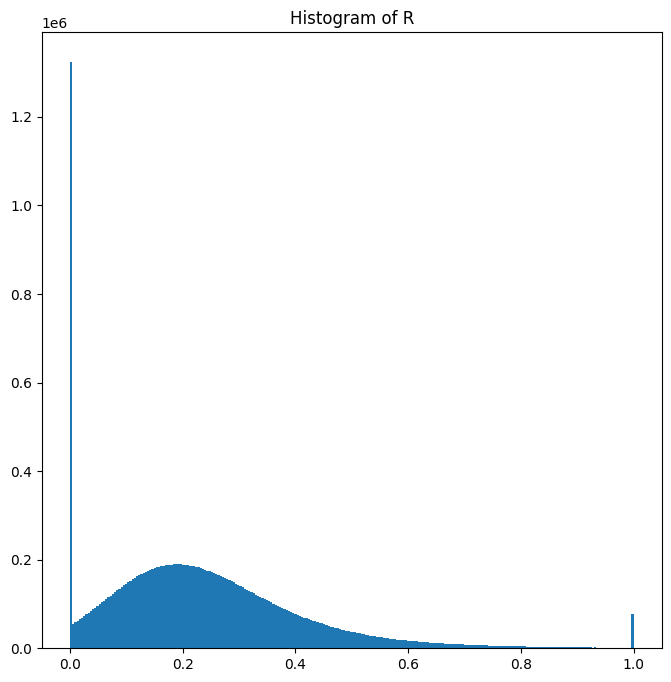

In [27]:
M1 = ma.masked_less_equal(M1, 0.0) # we mask invalid values
print(M1.mask.astype(float).mean())

threshold=2.5*np.sqrt(M1.ravel()).mean()
print(f'threshold={threshold}')

M2 = ma.array(M2,mask=M1.mask,fill_value=np.nan)
R  = np.sqrt(M2-M1**2) # standard deviation
R  = np.divide(R, M1) # coefficient of variation
#plt.hist(R.ravel(),256); plt.show()

R0 = R
gam = R.ravel().mean() 
gam2 =R.ravel().std()
print(f'Empirical mean of CV={gam}')
print(f'Empirical std of CV={gam2}')

# number of look estimate:
L  = ((0.991936+0.067646*gam-0.098888*gam**2 -0.048320*gam**3)/(0.001224-0.034323*gam+4.305577*gam**2-1.163498*gam**3))
print(f'Estimated L={L}')

sigma_factor= 8.0 # factor used for CV normalization, the higher the value, the less the number of outliers
CV = np.sqrt((L*gamma(L)**2/(gamma(L+0.5)**2))-1); # theoretical mean value
print(f'CV theoretical mean value={CV}')

gamL=gamma(L)
gamLd=gamma(L+0.5)
num=(L*gamL**4.*(4*(L**2)*gamL**2-4*L*gamLd**2-gamLd**2));
den=(gamLd**4.*(L*gamL**2-gamLd**2));
alpha=1/4*num/den; # theoretical variance value
sigma= np.sqrt(1.0/N*alpha)
print(f'theoretical standard deviation value={sigma}')


R =(R-CV)/(sigma_factor*sigma)+0.25; # normalization of C
R=(R>1)*np.ones([nx,ny])+(R<1)*R;   # Cast Coefficient of Varation R max to 1.
R=(R>0)*R;

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Histogram of R")
plt.hist(R.ravel(),256); plt.show()

## 4.3 Computation Of A HSV Composite

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/HSV_color_solid_cylinder_saturation_gray.png/394px-HSV_color_solid_cylinder_saturation_gray.png)

* Hue= Controls the color, we can put 0 or Kmax
* Saturation= Intensity of the color controlled by R
* Value= Luminance controlled by the maxium amplitude


Text(0.5, 1.0, 'HSV Composite (changes appear in red and cyan)')

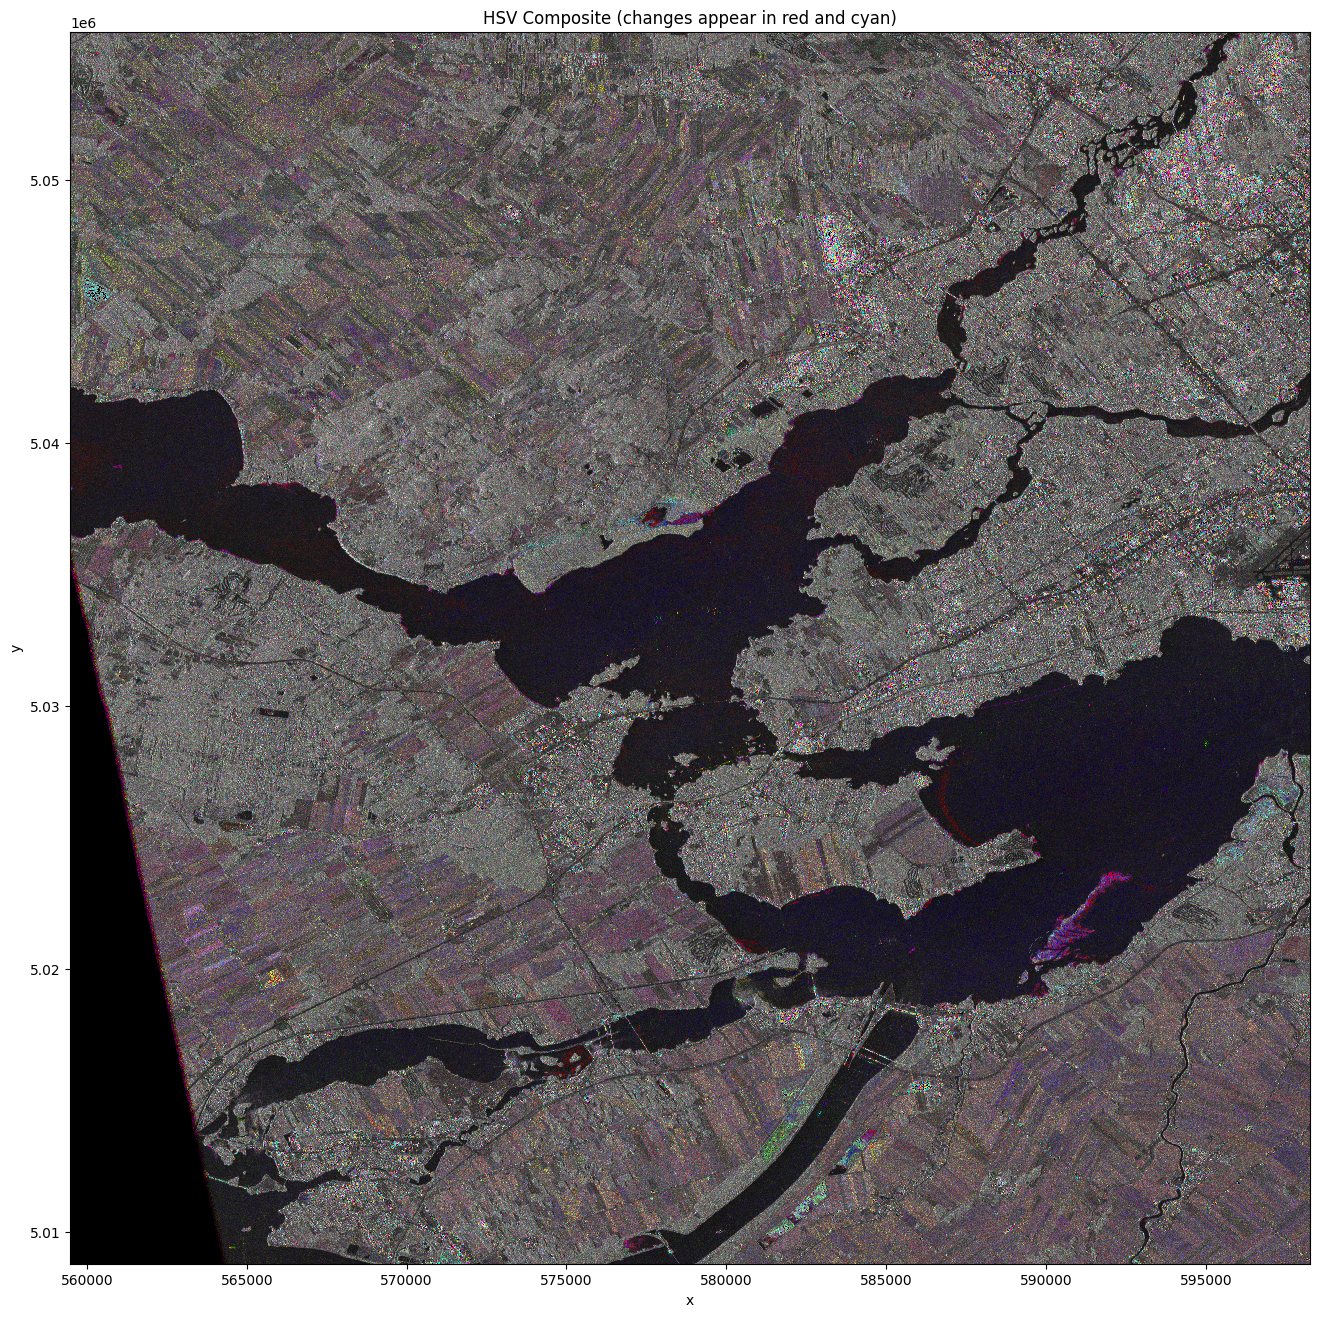

In [30]:
#Imax= M1
Imax2=(Imax/threshold); # Cast max Intensity to threshold. 
Imax2=(Imax2<1)*Imax2+(Imax2>1)*np.ones([nx,ny])
Idiff= np.abs(Imax-Imin)/(threshold)
Idiff=(Idiff<1)*Idiff+(Idiff>1)*np.ones([nx,ny])

hsv=np.zeros([nx,ny,3])
hsv[:, :, 0]=Kmax #Kmax hue will represent the temporal position of the maximum
hsv[:, :, 1]=R # saturation will depend on CV outliers (temporal variation)
hsv[:, :, 2]=Imax2 # observed maximum amplitude is controlling the luminance
C=color.hsv2rgb(hsv)
# plt.imshow(C)

temp= img_file[1].copy()
temp.values= (C[:,:,0]*256).astype('uint8')
temp= addArrayToDataArray(temp,(C[:,:,1]*256).astype('uint8'))
temp= addArrayToDataArray(temp,(C[:,:,2]*256).astype('uint8'))

# Plot on a map
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1, 1, 1)
temp.plot.imshow(rgb="band")
ax.set_title("HSV Composite (changes appear in red and cyan)")

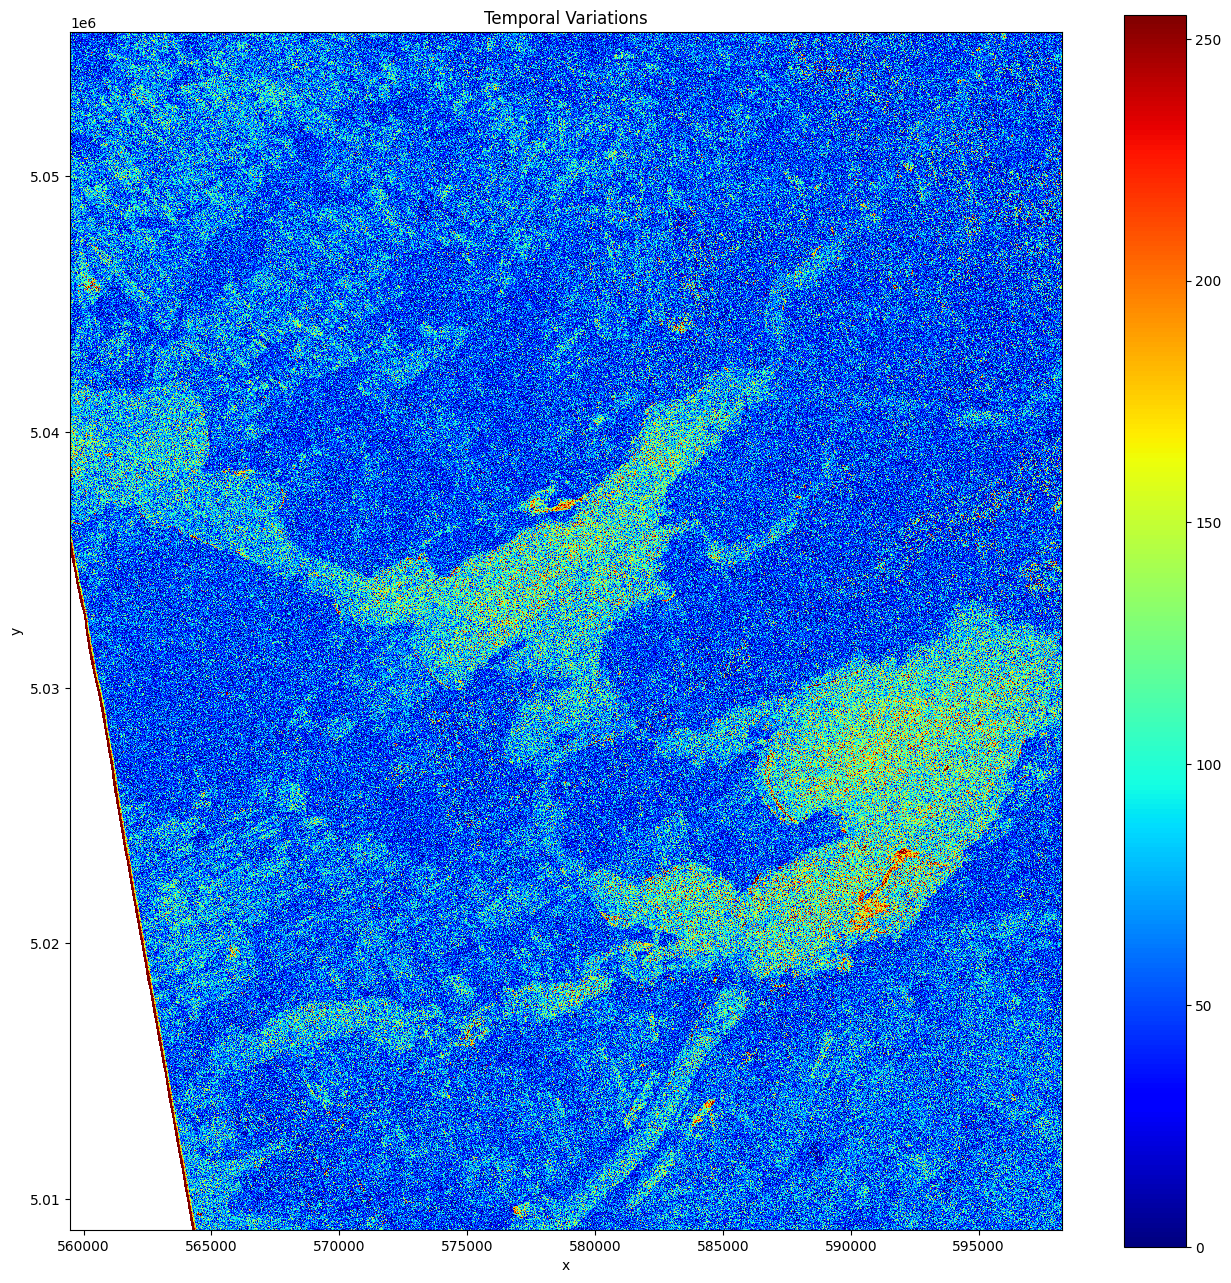

In [31]:
da2= xr.DataArray((R*255).astype('int16'), coords={'y':temp.coords['y'], 'x':temp.coords['x']}, dims=['y', 'x'])
da2.rename('R')
da2.to_netcdf('R2.nc')


fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1, 1, 1)

da2.plot.imshow(vmin=0,vmax=255.0, cmap= 'jet')
ax.set_title("Temporal Variations")
ax.set_aspect('equal')

# 5. Publish To Catalog

To publish your final results you can use the NCML to STAC Git repository. It can convert a NCML XML with NetCDF file reference to a STAC Item JSON definition.

The steps to use it are defined in README of the Git repository:
* [ncml2stac](https://github.com/crim-ca/ncml2stac)

There is also a notebook example:
* [NCML metadata conversion to STAC Item using CWL Application Package annotation](https://github.com/crim-ca/ncml2stac/blob/main/notebooks/ncml2stac.ipynb)
